In [3]:
import os
import cv2
import h5py
import torch
import numpy as np
import random
import sys

import torch.nn.functional as F
from tqdm import tqdm


###############################################################################
#                               SSIM on GPU                                   #
###############################################################################
def ssim_pytorch(img1, img2, window_size=11, window_sigma=1.5):
    """
    Compute SSIM between two grayscale images using PyTorch.
    Expects img1, img2: (N, 1, H, W) on the same device.
    Returns average SSIM (float).
    """
    device = img1.device
    C1 = 0.01**2
    C2 = 0.03**2

    # Build Gaussian Kernel
    coords = torch.arange(window_size, dtype=torch.float32, device=device)
    coords -= window_size // 2
    g = torch.exp(-(coords**2) / (2 * window_sigma**2))
    g /= g.sum()
    kernel2d = g.unsqueeze(1) * g.unsqueeze(0)
    kernel2d = kernel2d.view(1, 1, window_size, window_size)

    mu1 = F.conv2d(img1, kernel2d, padding=window_size//2, groups=1)
    mu2 = F.conv2d(img2, kernel2d, padding=window_size//2, groups=1)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, kernel2d, padding=window_size//2, groups=1) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, kernel2d, padding=window_size//2, groups=1) - mu2_sq
    sigma12   = F.conv2d(img1 * img2, kernel2d, padding=window_size//2, groups=1) - mu1_mu2

    numerator   = (2.0 * mu1_mu2 + C1) * (2.0 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map    = numerator / denominator

    return ssim_map.mean()


###############################################################################
#                          GPU-BASED IMAGE SCALING                             #
###############################################################################
def gpu_resize(tensor_batch, scale_factor):
    """
    Resizes a batch of images on the GPU using bilinear interpolation.
    Expects 'tensor_batch' shape: (N, C, H, W) on GPU.
    Returns resized (N, C, H', W') on GPU,
    where H' = H*scale_factor, W' = W*scale_factor (rounded).
    """
    _, _, old_h, old_w = tensor_batch.shape
    new_h = int(old_h * scale_factor)
    new_w = int(old_w * scale_factor)
    return F.interpolate(tensor_batch, size=(new_h, new_w), mode='bilinear', align_corners=False)


###############################################################################
#                        Main Dataset Generation                              #
###############################################################################
def generate_dataset(
    video_dir='bdd100k/videos',
    output_prefix='frame_pairs',
    input_scale=1/8,
    output_scale=1/4,
    sim_threshold=0.95,
    buffer_size=500,
    max_videos=None,
    # New config options
    use_float16=False,
    use_compression=False,
    compression_level=4,
    fixed_orig_size=(160, 90),   # (width, height) for original images -> final shape (3,90,160)
    fixed_scaled_size=(320, 180) # (width, height) for scaled images -> final shape (3,180,320)
):
    """
    1) Scans the specified 'video_dir' for .mov files.
    2) Opens a single HDF5 file: 'output_prefix.h5'.
    3) For each video, reads frames, computes SSIM, and keeps consecutive pairs 
       that fall below the similarity threshold.
    4) Each pair is resized to fixed dimensions before being added to buffers.
    5) Stores each pair in buffers and flushes when buffer_size is reached.
    
    The HDF5 file will contain these datasets:
      - 'inputs_original'  (shape: (N, 3, fixed_orig_height, fixed_orig_width))
      - 'outputs_original' (same shape as above)
      - 'inputs_scaled'    (shape: (N, 3, fixed_scaled_height, fixed_scaled_width))
      - 'outputs_scaled'   (same shape as above)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info] Using device: {device}")

    # 1) List all .mov files in video_dir (ignoring case)
    if not os.path.isdir(video_dir):
        raise FileNotFoundError(f"Video directory '{video_dir}' not found.")
    video_filenames = [f for f in os.listdir(video_dir) if f.lower().endswith('.mov')]
    if max_videos is not None and max_videos > 0:
        video_filenames = video_filenames[:max_videos]
    print(f"[Info] Found {len(video_filenames)} videos (after max_videos limit).")

    # 2) Create a single HDF5 file with 4 datasets
    output_file = f"{output_prefix}.h5"
    print(f"[Info] Creating HDF5 file: {output_file}")
    np_dtype = np.float16 if use_float16 else np.float32
    comp_args = {}
    if use_compression:
        comp_args = {'compression': 'gzip', 'compression_opts': compression_level}

    h5f = h5py.File(output_file, 'w')
    ds_in_orig = h5f.create_dataset(
        'inputs_original',
        shape=(0, 3, fixed_orig_size[1], fixed_orig_size[0]),
        maxshape=(None, 3, fixed_orig_size[1], fixed_orig_size[0]),
        dtype=np_dtype,
        **comp_args
    )
    ds_out_orig = h5f.create_dataset(
        'outputs_original',
        shape=(0, 3, fixed_orig_size[1], fixed_orig_size[0]),
        maxshape=(None, 3, fixed_orig_size[1], fixed_orig_size[0]),
        dtype=np_dtype,
        **comp_args
    )
    ds_in_scl = h5f.create_dataset(
        'inputs_scaled',
        shape=(0, 3, fixed_scaled_size[1], fixed_scaled_size[0]),
        maxshape=(None, 3, fixed_scaled_size[1], fixed_scaled_size[0]),
        dtype=np_dtype,
        **comp_args
    )
    ds_out_scl = h5f.create_dataset(
        'outputs_scaled',
        shape=(0, 3, fixed_scaled_size[1], fixed_scaled_size[0]),
        maxshape=(None, 3, fixed_scaled_size[1], fixed_scaled_size[0]),
        dtype=np_dtype,
        **comp_args
    )

    total_count = 0
    buf_in_orig = []
    buf_out_orig = []
    buf_in_scl = []
    buf_out_scl = []

    # Helper to flush buffers to disk
    def flush_buffers():
        nonlocal total_count
        nb = len(buf_in_orig)
        if nb == 0:
            return

        print(f"[Flush] Writing {nb} pairs to file...")
        arr_in_orig = np.array(buf_in_orig, dtype=np_dtype)
        arr_out_orig = np.array(buf_out_orig, dtype=np_dtype)
        arr_in_scl = np.array(buf_in_scl, dtype=np_dtype)
        arr_out_scl = np.array(buf_out_scl, dtype=np_dtype)

        new_size = total_count + nb
        ds_in_orig.resize((new_size, 3, fixed_orig_size[1], fixed_orig_size[0]))
        ds_out_orig.resize((new_size, 3, fixed_orig_size[1], fixed_orig_size[0]))
        ds_in_scl.resize((new_size, 3, fixed_scaled_size[1], fixed_scaled_size[0]))
        ds_out_scl.resize((new_size, 3, fixed_scaled_size[1], fixed_scaled_size[0]))

        ds_in_orig[total_count:new_size] = arr_in_orig
        ds_out_orig[total_count:new_size] = arr_out_orig
        ds_in_scl[total_count:new_size] = arr_in_scl
        ds_out_scl[total_count:new_size] = arr_out_scl

        total_count = new_size
        print(f"[Flush] Total pairs so far: {total_count}")

        buf_in_orig.clear()
        buf_out_orig.clear()
        buf_in_scl.clear()
        buf_out_scl.clear()

    # Helper to resize an image array (shape: (3, H, W)) to a target size.
    def resize_image(np_img, target_size):
        # target_size: (width, height)
        # Convert to HxWxC for cv2.resize
        img_hwc = np.transpose(np_img, (1, 2, 0))
        resized = cv2.resize(img_hwc, target_size, interpolation=cv2.INTER_AREA)
        return np.transpose(resized, (2, 0, 1))

    # 3) Loop over videos & frames, select pairs based on SSIM threshold
    total_pairs = 0
    for idx, fname in enumerate(video_filenames, start=1):
        vid_path = os.path.join(video_dir, fname)
        if not os.path.isfile(vid_path):
            print(f"[Warning] Video file '{vid_path}' not found, skipping.")
            continue

        print(f"\n[{idx}/{len(video_filenames)}] Reading video: {fname}")
        cap = cv2.VideoCapture(vid_path)
        frames_rgb = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # BGR -> RGB conversion
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_rgb.append(frame_rgb)
        cap.release()
        print(f"  -> Read {len(frames_rgb)} frames.")

        if len(frames_rgb) < 2:
            print("  -> Not enough frames for pairs. Skipping this video.")
            continue

        with tqdm(range(len(frames_rgb)-1), desc=f"Pairwise SSIM ({fname})", leave=True) as pbar:
            for i in pbar:
                f1 = frames_rgb[i]
                f2 = frames_rgb[i+1]

                # Compute SSIM on GPU for grayscale
                t1 = torch.from_numpy(cv2.cvtColor(f1, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device)
                t2 = torch.from_numpy(cv2.cvtColor(f2, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device)
                val = ssim_pytorch(t1, t2)
                if val.item() < sim_threshold:
                    # Convert color frames to tensor
                    tcolor1_orig = torch.from_numpy(f1).permute(2, 0, 1).float().unsqueeze(0).to(device)
                    tcolor2_orig = torch.from_numpy(f2).permute(2, 0, 1).float().unsqueeze(0).to(device)

                    # GPU-based scaling (for scaled version)
                    tcolor1_scaled = gpu_resize(tcolor1_orig, input_scale)
                    tcolor2_scaled = gpu_resize(tcolor2_orig, output_scale)

                    # Move tensors to CPU and remove batch dimension
                    np_in_orig  = tcolor1_orig.cpu().numpy()[0]
                    np_out_orig = tcolor2_orig.cpu().numpy()[0]
                    np_in_scaled  = tcolor1_scaled.cpu().numpy()[0]
                    np_out_scaled = tcolor2_scaled.cpu().numpy()[0]

                    # Optionally convert data types
                    if use_float16:
                        np_in_orig   = np_in_orig.astype(np.float16)
                        np_out_orig  = np_out_orig.astype(np.float16)
                        np_in_scaled = np_in_scaled.astype(np.float16)
                        np_out_scaled= np_out_scaled.astype(np.float16)
                    else:
                        np_in_orig   = np_in_orig.astype(np.float32)
                        np_out_orig  = np_out_orig.astype(np.float32)
                        np_in_scaled = np_in_scaled.astype(np.float32)
                        np_out_scaled= np_out_scaled.astype(np.float32)

                    # Resize to fixed dimensions
                    np_in_orig  = resize_image(np_in_orig, fixed_orig_size)
                    np_out_orig = resize_image(np_out_orig, fixed_orig_size)
                    np_in_scaled  = resize_image(np_in_scaled, fixed_scaled_size)
                    np_out_scaled = resize_image(np_out_scaled, fixed_scaled_size)

                    buf_in_orig.append(np_in_orig)
                    buf_out_orig.append(np_out_orig)
                    buf_in_scl.append(np_in_scaled)
                    buf_out_scl.append(np_out_scaled)
                    total_pairs += 1

                    if len(buf_in_orig) >= buffer_size:
                        flush_buffers()

        print(f"  -> Done processing video {fname} with {len(frames_rgb)-1} possible pairs.")

    print(f"\n[Info] Total frame pairs passing SSIM threshold: {total_pairs}")
    print("[Info] Flushing any remaining buffers...")
    flush_buffers()

    print(f"[Info] Wrote {total_count} pairs to '{output_file}'")
    h5f.flush()
    h5f.close()
    print("[Info] All done! Exiting now.")


###############################################################################
#                               Script Entry-Point                            #
###############################################################################
if __name__ == '__main__':
    generate_dataset(
        video_dir='bdd100k/videos',
        output_prefix='frame_pairs',
        input_scale=1/8,
        output_scale=1/4,
        sim_threshold=0.96,
        buffer_size=500,
        max_videos=20,     # For example, process only 2 videos
        use_float16=False,
        use_compression=False,
        compression_level=5,
        fixed_orig_size=(160, 90),
        fixed_scaled_size=(320, 180)
    )


[Info] Using device: cuda
[Info] Found 20 videos (after max_videos limit).
[Info] Creating HDF5 file: frame_pairs.h5

[1/20] Reading video: 0000f77c-cb820c98.mov
  -> Read 1215 frames.


Pairwise SSIM (0000f77c-cb820c98.mov):  41%|████      | 495/1214 [00:12<00:18, 39.50it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0000f77c-cb820c98.mov):  41%|████      | 500/1214 [00:13<00:56, 12.63it/s]

[Flush] Total pairs so far: 500


Pairwise SSIM (0000f77c-cb820c98.mov):  82%|████████▏ | 995/1214 [00:23<00:04, 52.42it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0000f77c-cb820c98.mov):  82%|████████▏ | 1001/1214 [00:24<00:11, 18.83it/s]

[Flush] Total pairs so far: 1000


Pairwise SSIM (0000f77c-cb820c98.mov): 100%|██████████| 1214/1214 [00:28<00:00, 42.76it/s]


  -> Done processing video 0000f77c-cb820c98.mov with 1214 possible pairs.

[2/20] Reading video: 0001542f-5ce3cf52.mov
  -> Read 1213 frames.


Pairwise SSIM (0001542f-5ce3cf52.mov):  23%|██▎       | 283/1212 [00:05<00:18, 51.02it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0001542f-5ce3cf52.mov):  24%|██▍       | 289/1212 [00:06<00:53, 17.31it/s]

[Flush] Total pairs so far: 1500


Pairwise SSIM (0001542f-5ce3cf52.mov):  64%|██████▍   | 781/1212 [00:16<00:08, 51.00it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0001542f-5ce3cf52.mov):  65%|██████▍   | 787/1212 [00:17<00:23, 17.75it/s]

[Flush] Total pairs so far: 2000


Pairwise SSIM (0001542f-5ce3cf52.mov): 100%|██████████| 1212/1212 [00:25<00:00, 46.88it/s]


  -> Done processing video 0001542f-5ce3cf52.mov with 1212 possible pairs.

[3/20] Reading video: 0001542f-ec815219.mov
  -> Read 1208 frames.


Pairwise SSIM (0001542f-ec815219.mov):   6%|▌         | 72/1207 [00:01<00:22, 50.52it/s]

[Flush] Writing 500 pairs to file...
[Flush] Total pairs so far: 2500


Pairwise SSIM (0001542f-ec815219.mov):  47%|████▋     | 571/1207 [00:12<00:12, 51.92it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0001542f-ec815219.mov):  48%|████▊     | 577/1207 [00:12<00:35, 17.62it/s]

[Flush] Total pairs so far: 3000


Pairwise SSIM (0001542f-ec815219.mov):  89%|████████▉ | 1073/1207 [00:22<00:02, 55.09it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0001542f-ec815219.mov):  89%|████████▉ | 1079/1207 [00:23<00:07, 17.58it/s]

[Flush] Total pairs so far: 3500


Pairwise SSIM (0001542f-ec815219.mov): 100%|██████████| 1207/1207 [00:26<00:00, 46.02it/s]


  -> Done processing video 0001542f-ec815219.mov with 1207 possible pairs.

[4/20] Reading video: 00054602-3bf57337.mov
  -> Read 1223 frames.


Pairwise SSIM (00054602-3bf57337.mov):  30%|██▉       | 366/1222 [00:09<00:22, 38.15it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00054602-3bf57337.mov):  30%|███       | 370/1222 [00:10<01:09, 12.25it/s]

[Flush] Total pairs so far: 4000


Pairwise SSIM (00054602-3bf57337.mov):  71%|███████   | 866/1222 [00:21<00:06, 52.70it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00054602-3bf57337.mov):  71%|███████▏  | 872/1222 [00:22<00:21, 16.54it/s]

[Flush] Total pairs so far: 4500


Pairwise SSIM (00054602-3bf57337.mov): 100%|██████████| 1222/1222 [00:28<00:00, 42.44it/s]


  -> Done processing video 00054602-3bf57337.mov with 1222 possible pairs.

[5/20] Reading video: 00067cfb-5adfaaa7.mov
  -> Read 1214 frames.


Pairwise SSIM (00067cfb-5adfaaa7.mov):  12%|█▏        | 144/1213 [00:03<00:21, 50.34it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00067cfb-5adfaaa7.mov):  12%|█▏        | 150/1213 [00:04<01:05, 16.26it/s]

[Flush] Total pairs so far: 5000


Pairwise SSIM (00067cfb-5adfaaa7.mov):  53%|█████▎    | 642/1213 [00:13<00:11, 50.63it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00067cfb-5adfaaa7.mov):  53%|█████▎    | 648/1213 [00:14<00:31, 17.99it/s]

[Flush] Total pairs so far: 5500


Pairwise SSIM (00067cfb-5adfaaa7.mov):  94%|█████████▍| 1144/1213 [00:24<00:01, 51.02it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00067cfb-5adfaaa7.mov):  95%|█████████▍| 1150/1213 [00:25<00:04, 14.49it/s]

[Flush] Total pairs so far: 6000


Pairwise SSIM (00067cfb-5adfaaa7.mov): 100%|██████████| 1213/1213 [00:26<00:00, 45.58it/s]


  -> Done processing video 00067cfb-5adfaaa7.mov with 1213 possible pairs.

[6/20] Reading video: 00067cfb-caba8a02.mov
  -> Read 1206 frames.


Pairwise SSIM (00067cfb-caba8a02.mov):  36%|███▌      | 429/1205 [00:08<00:15, 50.76it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00067cfb-caba8a02.mov):  36%|███▌      | 435/1205 [00:09<00:46, 16.46it/s]

[Flush] Total pairs so far: 6500


Pairwise SSIM (00067cfb-caba8a02.mov):  77%|███████▋  | 928/1205 [00:19<00:05, 50.30it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00067cfb-caba8a02.mov):  78%|███████▊  | 934/1205 [00:20<00:17, 15.07it/s]

[Flush] Total pairs so far: 7000


Pairwise SSIM (00067cfb-caba8a02.mov): 100%|██████████| 1205/1205 [00:25<00:00, 47.52it/s]


  -> Done processing video 00067cfb-caba8a02.mov with 1205 possible pairs.

[7/20] Reading video: 000e0252-8523a4a9.mov
  -> Read 1204 frames.


Pairwise SSIM (000e0252-8523a4a9.mov):  19%|█▊        | 223/1203 [00:04<00:17, 56.11it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (000e0252-8523a4a9.mov):  19%|█▉        | 229/1203 [00:05<01:07, 14.36it/s]

[Flush] Total pairs so far: 7500


Pairwise SSIM (000e0252-8523a4a9.mov):  60%|██████    | 724/1203 [00:15<00:09, 49.83it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (000e0252-8523a4a9.mov):  61%|██████    | 730/1203 [00:16<00:32, 14.73it/s]

[Flush] Total pairs so far: 8000


Pairwise SSIM (000e0252-8523a4a9.mov): 100%|██████████| 1203/1203 [00:25<00:00, 47.29it/s]


  -> Done processing video 000e0252-8523a4a9.mov with 1203 possible pairs.

[8/20] Reading video: 000f157f-37797ff9.mov
  -> Read 1205 frames.


Pairwise SSIM (000f157f-37797ff9.mov):   2%|▏         | 20/1204 [00:00<00:31, 37.21it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (000f157f-37797ff9.mov):   2%|▏         | 24/1204 [00:01<01:50, 10.65it/s]

[Flush] Total pairs so far: 8500


Pairwise SSIM (000f157f-37797ff9.mov):  43%|████▎     | 520/1204 [00:11<00:13, 50.73it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (000f157f-37797ff9.mov):  44%|████▎     | 526/1204 [00:12<00:50, 13.55it/s]

[Flush] Total pairs so far: 9000


Pairwise SSIM (000f157f-37797ff9.mov):  85%|████████▍ | 1022/1204 [00:22<00:03, 50.82it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (000f157f-37797ff9.mov):  85%|████████▌ | 1028/1204 [00:23<00:11, 15.88it/s]

[Flush] Total pairs so far: 9500


Pairwise SSIM (000f157f-37797ff9.mov): 100%|██████████| 1204/1204 [00:26<00:00, 45.08it/s]


  -> Done processing video 000f157f-37797ff9.mov with 1204 possible pairs.

[9/20] Reading video: 0010bf16-a457685b.mov
  -> Read 1207 frames.


Pairwise SSIM (0010bf16-a457685b.mov):  26%|██▋       | 317/1206 [00:06<00:17, 50.26it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0010bf16-a457685b.mov):  27%|██▋       | 329/1206 [00:07<00:41, 20.98it/s]

[Flush] Total pairs so far: 10000


Pairwise SSIM (0010bf16-a457685b.mov):  69%|██████▊   | 827/1206 [00:16<00:07, 52.33it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0010bf16-a457685b.mov):  69%|██████▉   | 838/1206 [00:18<00:19, 18.60it/s]

[Flush] Total pairs so far: 10500


Pairwise SSIM (0010bf16-a457685b.mov): 100%|██████████| 1206/1206 [00:25<00:00, 47.88it/s]


  -> Done processing video 0010bf16-a457685b.mov with 1206 possible pairs.

[10/20] Reading video: 00131ea7-624f538d.mov
  -> Read 1214 frames.


Pairwise SSIM (00131ea7-624f538d.mov):  11%|█         | 129/1213 [00:02<00:21, 50.07it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00131ea7-624f538d.mov):  11%|█         | 134/1213 [00:03<01:08, 15.81it/s]

[Flush] Total pairs so far: 11000


Pairwise SSIM (00131ea7-624f538d.mov):  52%|█████▏    | 627/1213 [00:13<00:11, 49.93it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00131ea7-624f538d.mov):  52%|█████▏    | 632/1213 [00:14<00:45, 12.89it/s]

[Flush] Total pairs so far: 11500


Pairwise SSIM (00131ea7-624f538d.mov):  95%|█████████▌| 1154/1213 [00:24<00:01, 50.25it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00131ea7-624f538d.mov):  96%|█████████▌| 1160/1213 [00:25<00:03, 16.01it/s]

[Flush] Total pairs so far: 12000


Pairwise SSIM (00131ea7-624f538d.mov): 100%|██████████| 1213/1213 [00:26<00:00, 46.43it/s]


  -> Done processing video 00131ea7-624f538d.mov with 1213 possible pairs.

[11/20] Reading video: 00134776-9123d227.mov
  -> Read 1204 frames.


Pairwise SSIM (00134776-9123d227.mov):  37%|███▋      | 448/1203 [00:08<00:14, 51.06it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00134776-9123d227.mov):  38%|███▊      | 454/1203 [00:10<00:51, 14.45it/s]

[Flush] Total pairs so far: 12500


Pairwise SSIM (00134776-9123d227.mov):  79%|███████▉  | 952/1203 [00:19<00:05, 48.47it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00134776-9123d227.mov):  80%|███████▉  | 957/1203 [00:20<00:17, 13.92it/s]

[Flush] Total pairs so far: 13000


Pairwise SSIM (00134776-9123d227.mov): 100%|██████████| 1203/1203 [00:25<00:00, 47.16it/s]


  -> Done processing video 00134776-9123d227.mov with 1203 possible pairs.

[12/20] Reading video: 001c5339-08faca55.mov
  -> Read 1210 frames.


Pairwise SSIM (001c5339-08faca55.mov):  20%|██        | 244/1209 [00:04<00:19, 50.70it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (001c5339-08faca55.mov):  21%|██        | 256/1209 [00:05<00:45, 21.18it/s]

[Flush] Total pairs so far: 13500


Pairwise SSIM (001c5339-08faca55.mov):  62%|██████▏   | 747/1209 [00:15<00:09, 50.36it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (001c5339-08faca55.mov):  62%|██████▏   | 753/1209 [00:16<00:28, 16.16it/s]

[Flush] Total pairs so far: 14000


Pairwise SSIM (001c5339-08faca55.mov): 100%|██████████| 1209/1209 [00:25<00:00, 47.76it/s]


  -> Done processing video 001c5339-08faca55.mov with 1209 possible pairs.

[13/20] Reading video: 00207869-902288d1.mov
  -> Read 1208 frames.


Pairwise SSIM (00207869-902288d1.mov):   3%|▎         | 40/1207 [00:01<00:25, 45.21it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00207869-902288d1.mov):   4%|▎         | 45/1207 [00:01<01:27, 13.35it/s]

[Flush] Total pairs so far: 14500


Pairwise SSIM (00207869-902288d1.mov):  44%|████▍     | 537/1207 [00:11<00:13, 51.43it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00207869-902288d1.mov):  45%|████▍     | 543/1207 [00:12<00:41, 15.86it/s]

[Flush] Total pairs so far: 15000


Pairwise SSIM (00207869-902288d1.mov): 100%|██████████| 1207/1207 [00:20<00:00, 59.56it/s] 


  -> Done processing video 00207869-902288d1.mov with 1207 possible pairs.

[14/20] Reading video: 0024b742-83709bd4.mov
  -> Read 1197 frames.


Pairwise SSIM (0024b742-83709bd4.mov):  15%|█▌        | 185/1196 [00:03<00:20, 50.08it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0024b742-83709bd4.mov):  16%|█▋        | 196/1196 [00:04<00:48, 20.45it/s]

[Flush] Total pairs so far: 15500


Pairwise SSIM (0024b742-83709bd4.mov):  57%|█████▋    | 687/1196 [00:14<00:10, 48.85it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0024b742-83709bd4.mov):  58%|█████▊    | 692/1196 [00:15<00:31, 16.16it/s]

[Flush] Total pairs so far: 16000


Pairwise SSIM (0024b742-83709bd4.mov):  99%|█████████▉| 1187/1196 [00:24<00:00, 51.01it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (0024b742-83709bd4.mov): 100%|█████████▉| 1193/1196 [00:25<00:00, 15.04it/s]

[Flush] Total pairs so far: 16500


Pairwise SSIM (0024b742-83709bd4.mov): 100%|██████████| 1196/1196 [00:25<00:00, 46.32it/s]


  -> Done processing video 0024b742-83709bd4.mov with 1196 possible pairs.

[15/20] Reading video: 00268999-a4b8e39d.mov
  -> Read 1198 frames.


Pairwise SSIM (00268999-a4b8e39d.mov):  41%|████      | 491/1197 [00:09<00:14, 49.79it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00268999-a4b8e39d.mov):  41%|████▏     | 496/1197 [00:10<00:47, 14.64it/s]

[Flush] Total pairs so far: 17000


Pairwise SSIM (00268999-a4b8e39d.mov):  83%|████████▎ | 992/1197 [00:20<00:04, 50.40it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (00268999-a4b8e39d.mov):  83%|████████▎ | 998/1197 [00:21<00:13, 14.78it/s]

[Flush] Total pairs so far: 17500


Pairwise SSIM (00268999-a4b8e39d.mov): 100%|██████████| 1197/1197 [00:25<00:00, 47.71it/s]


  -> Done processing video 00268999-a4b8e39d.mov with 1197 possible pairs.

[16/20] Reading video: 002ab96a-ea678692.mov
  -> Read 1204 frames.


Pairwise SSIM (002ab96a-ea678692.mov):  24%|██▍       | 293/1203 [00:05<00:17, 51.05it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002ab96a-ea678692.mov):  25%|██▍       | 299/1203 [00:06<00:50, 17.81it/s]

[Flush] Total pairs so far: 18000


Pairwise SSIM (002ab96a-ea678692.mov):  66%|██████▌   | 795/1203 [00:16<00:08, 48.37it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002ab96a-ea678692.mov):  67%|██████▋   | 800/1203 [00:17<00:28, 14.21it/s]

[Flush] Total pairs so far: 18500


Pairwise SSIM (002ab96a-ea678692.mov): 100%|██████████| 1203/1203 [00:25<00:00, 47.53it/s]


  -> Done processing video 002ab96a-ea678692.mov with 1203 possible pairs.

[17/20] Reading video: 002b485a-3f6603f2.mov
  -> Read 1203 frames.


Pairwise SSIM (002b485a-3f6603f2.mov):   8%|▊         | 92/1202 [00:02<00:21, 51.32it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002b485a-3f6603f2.mov):   8%|▊         | 98/1202 [00:02<01:04, 17.23it/s]

[Flush] Total pairs so far: 19000


Pairwise SSIM (002b485a-3f6603f2.mov):  49%|████▉     | 592/1202 [00:12<00:11, 51.46it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002b485a-3f6603f2.mov):  50%|████▉     | 598/1202 [00:13<00:41, 14.55it/s]

[Flush] Total pairs so far: 19500


Pairwise SSIM (002b485a-3f6603f2.mov):  91%|█████████ | 1090/1202 [00:22<00:02, 49.05it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002b485a-3f6603f2.mov):  92%|█████████▏| 1100/1202 [00:23<00:05, 18.35it/s]

[Flush] Total pairs so far: 20000


Pairwise SSIM (002b485a-3f6603f2.mov): 100%|██████████| 1202/1202 [00:25<00:00, 46.31it/s]


  -> Done processing video 002b485a-3f6603f2.mov with 1202 possible pairs.

[18/20] Reading video: 002cd38e-ebe888e1.mov
  -> Read 1204 frames.


Pairwise SSIM (002cd38e-ebe888e1.mov):  33%|███▎      | 391/1203 [00:07<00:15, 51.29it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002cd38e-ebe888e1.mov):  33%|███▎      | 397/1203 [00:08<00:46, 17.42it/s]

[Flush] Total pairs so far: 20500


Pairwise SSIM (002cd38e-ebe888e1.mov):  74%|███████▍  | 891/1203 [00:17<00:06, 50.96it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002cd38e-ebe888e1.mov):  75%|███████▍  | 897/1203 [00:18<00:17, 17.12it/s]

[Flush] Total pairs so far: 21000


Pairwise SSIM (002cd38e-ebe888e1.mov): 100%|██████████| 1203/1203 [00:24<00:00, 49.10it/s]


  -> Done processing video 002cd38e-ebe888e1.mov with 1203 possible pairs.

[19/20] Reading video: 002d290d-01969e7d.mov
  -> Read 1204 frames.


Pairwise SSIM (002d290d-01969e7d.mov):  16%|█▌        | 188/1203 [00:03<00:19, 51.27it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002d290d-01969e7d.mov):  16%|█▌        | 194/1203 [00:04<00:58, 17.29it/s]

[Flush] Total pairs so far: 21500


Pairwise SSIM (002d290d-01969e7d.mov):  57%|█████▋    | 689/1203 [00:14<00:10, 48.58it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002d290d-01969e7d.mov):  58%|█████▊    | 694/1203 [00:15<00:32, 15.59it/s]

[Flush] Total pairs so far: 22000


Pairwise SSIM (002d290d-01969e7d.mov):  99%|█████████▉| 1189/1203 [00:25<00:00, 50.06it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002d290d-01969e7d.mov):  99%|█████████▉| 1195/1203 [00:25<00:00, 17.74it/s]

[Flush] Total pairs so far: 22500


Pairwise SSIM (002d290d-01969e7d.mov): 100%|██████████| 1203/1203 [00:26<00:00, 46.22it/s]


  -> Done processing video 002d290d-01969e7d.mov with 1203 possible pairs.

[20/20] Reading video: 002d290d-90f2bab2.mov
  -> Read 1210 frames.


Pairwise SSIM (002d290d-90f2bab2.mov):  40%|████      | 484/1209 [00:09<00:13, 54.42it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002d290d-90f2bab2.mov):  41%|████      | 490/1209 [00:10<00:41, 17.20it/s]

[Flush] Total pairs so far: 23000


Pairwise SSIM (002d290d-90f2bab2.mov):  81%|████████▏ | 983/1209 [00:19<00:04, 52.47it/s]

[Flush] Writing 500 pairs to file...


Pairwise SSIM (002d290d-90f2bab2.mov):  82%|████████▏ | 989/1209 [00:20<00:12, 17.62it/s]

[Flush] Total pairs so far: 23500


Pairwise SSIM (002d290d-90f2bab2.mov): 100%|██████████| 1209/1209 [00:24<00:00, 48.92it/s]


  -> Done processing video 002d290d-90f2bab2.mov with 1209 possible pairs.

[Info] Total frame pairs passing SSIM threshold: 23722
[Info] Flushing any remaining buffers...
[Flush] Writing 222 pairs to file...
[Flush] Total pairs so far: 23722
[Info] Wrote 23722 pairs to 'frame_pairs.h5'
[Info] All done! Exiting now.


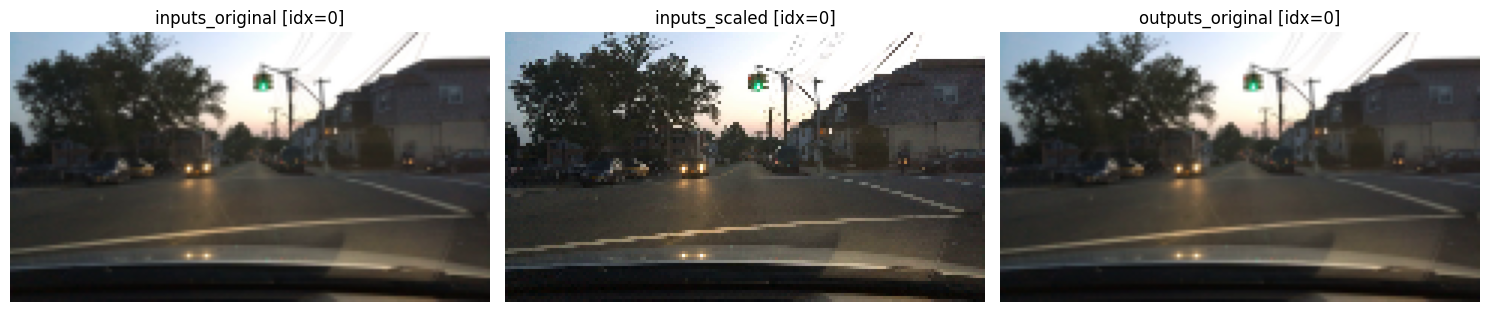

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_three_datasets(h5_path, index=0):
    """
    Attempts to visualize three datasets for the same 'index':
      1) 'inputs_original'
      2) 'inputs_scaled'
      3) 'outputs_original'

    Each dataset is expected to be shaped (N, 3, H, W).
    If a dataset doesn't exist or is empty, we skip it.

    We apply a logic:
      1) If max pixel > 2.0, assume the data is [0,255] => divide by 255
      2) Otherwise, apply a min–max stretch to improve visibility
    """
    if not os.path.exists(h5_path):
        print(f"H5 file '{h5_path}' does not exist.")
        return

    datasets_to_show = [
        "inputs_original",
        "inputs_scaled",
        "outputs_original"
    ]

    with h5py.File(h5_path, 'r') as f:
        images_to_plot = []

        for ds_name in datasets_to_show:
            if ds_name not in f:
                print(f"[Warning] Dataset '{ds_name}' not found. Skipping.")
                continue

            ds = f[ds_name]
            if ds.shape[0] == 0:
                print(f"[Warning] Dataset '{ds_name}' is empty. Skipping.")
                continue

            if index >= ds.shape[0]:
                print(f"[Warning] Index {index} out of range for '{ds_name}' "
                      f"(has {ds.shape[0]} samples). Skipping.")
                continue

            # Retrieve the sample: shape=(3,H,W)
            sample = ds[index]

            # Transpose to (H,W,3) for matplotlib
            sample_rgb = np.transpose(sample, (1, 2, 0))

            # Step 1) Check if data is in [0,255] range
            pixel_min, pixel_max = sample_rgb.min(), sample_rgb.max()

            if pixel_max > 2.0:
                # Probably 0..255 => scale to 0..1
                sample_rgb = sample_rgb / 255.0
                # Recompute min, max after dividing
                pixel_min, pixel_max = sample_rgb.min(), sample_rgb.max()

            # Step 2) Now apply min–max auto-contrast if there's variation
            if pixel_max - pixel_min > 1e-8:
                sample_rgb = (sample_rgb - pixel_min) / (pixel_max - pixel_min)
            else:
                # If everything is the same value, the image is basically uniform
                sample_rgb = np.clip(sample_rgb, 0, 1)

            images_to_plot.append((ds_name, sample_rgb))

    if not images_to_plot:
        print("\nNo valid data found to visualize. Exiting.")
        return

    # Plot side by side
    num_plots = len(images_to_plot)
    plt.figure(figsize=(5 * num_plots, 4))

    for i, (ds_name, img) in enumerate(images_to_plot, start=1):
        plt.subplot(1, num_plots, i)
        plt.imshow(img)
        plt.title(f"{ds_name} [idx={index}]")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    h5_file = "frame_pairs.h5"
    visualize_three_datasets(h5_file, index=0)
